In [833]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [834]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [835]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


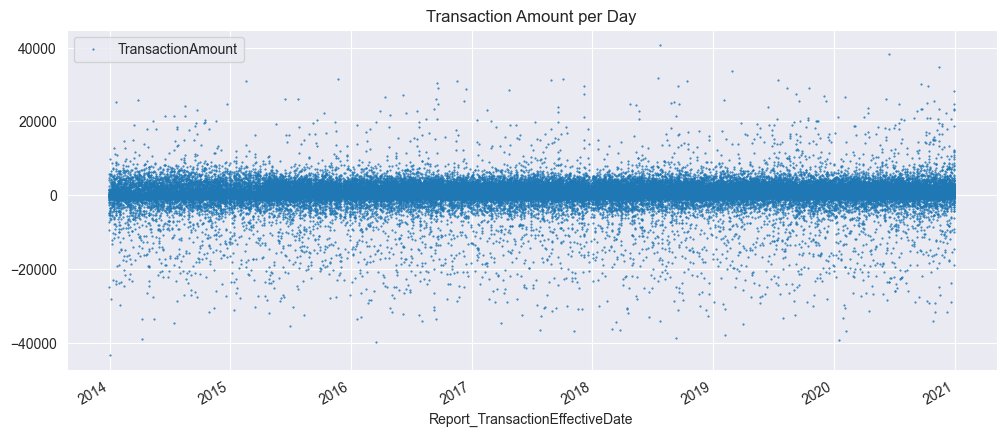

In [836]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [837]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,1763.692730
2020-12-28,1763.692730
2020-12-29,82156.304473


In [838]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 98


In [839]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

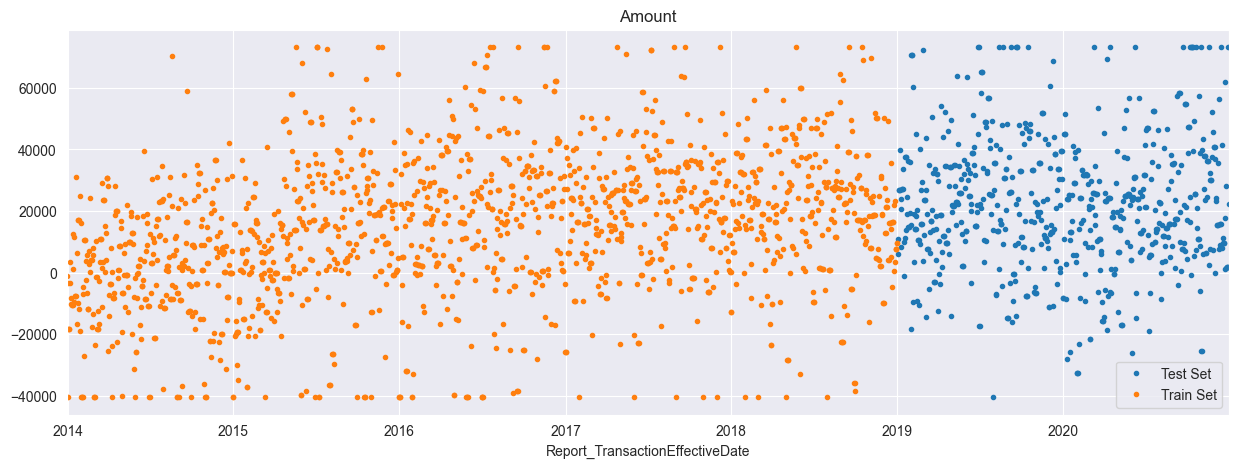

In [840]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [841]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [842]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,39341.466845,10.580060
1,2013-12-31,-40417.380574,1.000000,0.693147
2,2014-01-01,-3465.890925,36952.489649,10.517415
3,2014-01-02,-40417.380574,1.000000,0.693147
4,2014-01-03,-18386.381900,22031.998674,10.000297
...,...,...,...,...
1824,2018-12-28,7577.044740,47995.425314,10.778882
1825,2018-12-29,7577.044740,47995.425314,10.778882
1826,2018-12-30,7577.044740,47995.425314,10.778882
1827,2018-12-31,9481.245786,49899.626360,10.817789


In [843]:
%%time
model = Prophet(
    seasonality_prior_scale=1  ,
    yearly_seasonality=10,
    weekly_seasonality=5,
    daily_seasonality=False,
    changepoint_prior_scale=0.0005,
    changepoint_range=0.9,
    seasonality_mode='multiplicative',
    interval_width=0.95,
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

model.fit(data_train_prophet)

13:25:24 - cmdstanpy - INFO - Chain [1] start processing
13:25:24 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 266 ms
Wall time: 507 ms


In [844]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-02,10.731069,5.521186,12.206451,10.731069,10.731069,-0.121664,-0.121664,-0.121664,-0.178786,...,-0.004586,-0.004586,-0.004586,-0.052536,-0.052536,-0.052536,0.0,0.0,0.0,8.812500
1,2019-01-03,10.731253,5.599252,12.406245,10.731253,10.731253,-0.101595,-0.101595,-0.101595,-0.154311,...,-0.001942,-0.001942,-0.001942,-0.050774,-0.050774,-0.050774,0.0,0.0,0.0,9.075301
2,2019-01-04,10.731438,6.169650,12.641957,10.731438,10.731438,-0.062418,-0.062418,-0.062418,-0.123857,...,-0.013011,-0.013011,-0.013011,-0.048428,-0.048428,-0.048428,0.0,0.0,0.0,9.402273
3,2019-01-05,10.731623,6.405517,13.384762,10.731623,10.731623,-0.023168,-0.023168,-0.023168,-0.079489,...,-0.010737,-0.010737,-0.010737,-0.045584,-0.045584,-0.045584,0.0,0.0,0.0,9.878577
4,2019-01-06,10.731808,6.747588,13.683202,10.731808,10.731808,0.002512,0.002512,0.002512,-0.047438,...,-0.007611,-0.007611,-0.007611,-0.042339,-0.042339,-0.042339,0.0,0.0,0.0,10.222710


In [845]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.731069,5.521186,12.206451,10.731069,10.731069,-0.121664,-0.121664,-0.121664,-0.178786,...,-0.004586,-0.004586,-0.052536,-0.052536,-0.052536,0.0,0.0,0.0,8.812500,-33700.690156
1,2019-01-03,10.731253,5.599252,12.406245,10.731253,10.731253,-0.101595,-0.101595,-0.101595,-0.154311,...,-0.001942,-0.001942,-0.050774,-0.050774,-0.050774,0.0,0.0,0.0,9.075301,-31681.562263
2,2019-01-04,10.731438,6.169650,12.641957,10.731438,10.731438,-0.062418,-0.062418,-0.062418,-0.123857,...,-0.013011,-0.013011,-0.048428,-0.048428,-0.048428,0.0,0.0,0.0,9.402273,-28302.497650
3,2019-01-05,10.731623,6.405517,13.384762,10.731623,10.731623,-0.023168,-0.023168,-0.023168,-0.079489,...,-0.010737,-0.010737,-0.045584,-0.045584,-0.045584,0.0,0.0,0.0,9.878577,-20910.435550
4,2019-01-06,10.731808,6.747588,13.683202,10.731808,10.731808,0.002512,0.002512,0.002512,-0.047438,...,-0.007611,-0.007611,-0.042339,-0.042339,-0.042339,0.0,0.0,0.0,10.222710,-12897.241532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.865036,7.272502,14.348929,10.865020,10.865052,0.029245,0.029245,0.029245,-0.027726,...,-0.007611,-0.007611,-0.049360,-0.049360,-0.049360,0.0,0.0,0.0,10.563796,-1710.593883
726,2020-12-28,10.865220,7.944020,14.501205,10.865205,10.865237,0.031930,0.031930,0.031930,0.014263,...,0.034000,0.034000,-0.051667,-0.051667,-0.051667,0.0,0.0,0.0,11.020195,20677.201891
727,2020-12-29,10.865405,7.376048,13.993364,10.865389,10.865422,0.031172,0.031172,0.031172,-0.018138,...,0.003887,0.003887,-0.053198,-0.053198,-0.053198,0.0,0.0,0.0,10.668326,2554.549758
728,2020-12-30,10.865590,7.092156,13.638158,10.865574,10.865606,0.014435,0.014435,0.014435,-0.044098,...,-0.004586,-0.004586,-0.053947,-0.053947,-0.053947,0.0,0.0,0.0,10.386434,-8001.510825


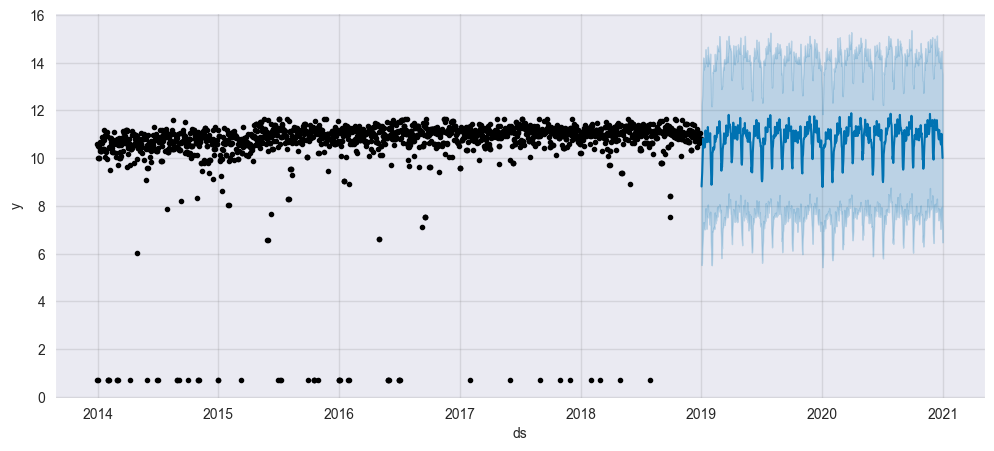

In [846]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [847]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


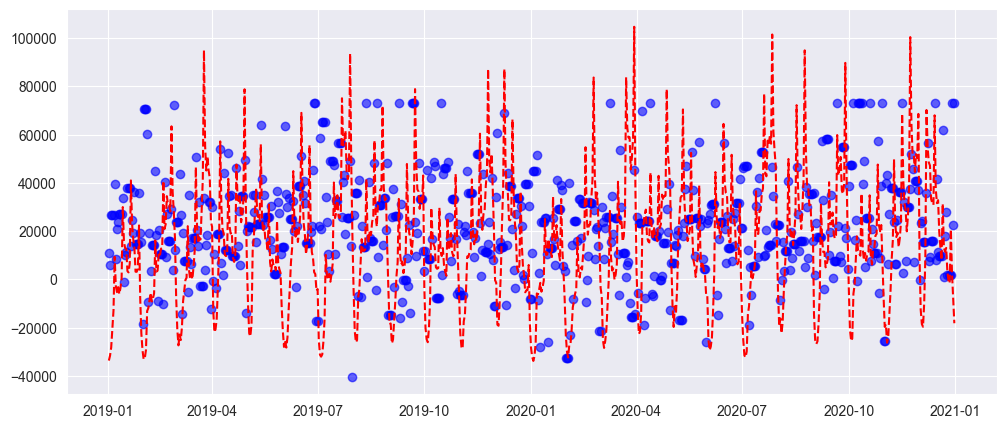

In [848]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [849]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.731069,5.521186,12.206451,10.731069,10.731069,-0.121664,-0.121664,-0.121664,-0.178786,...,-0.004586,-0.004586,-0.052536,-0.052536,-0.052536,0.0,0.0,0.0,8.812500,-33700.690156
1,2019-01-03,10.731253,5.599252,12.406245,10.731253,10.731253,-0.101595,-0.101595,-0.101595,-0.154311,...,-0.001942,-0.001942,-0.050774,-0.050774,-0.050774,0.0,0.0,0.0,9.075301,-31681.562263
2,2019-01-04,10.731438,6.169650,12.641957,10.731438,10.731438,-0.062418,-0.062418,-0.062418,-0.123857,...,-0.013011,-0.013011,-0.048428,-0.048428,-0.048428,0.0,0.0,0.0,9.402273,-28302.497650
3,2019-01-05,10.731623,6.405517,13.384762,10.731623,10.731623,-0.023168,-0.023168,-0.023168,-0.079489,...,-0.010737,-0.010737,-0.045584,-0.045584,-0.045584,0.0,0.0,0.0,9.878577,-20910.435550
4,2019-01-06,10.731808,6.747588,13.683202,10.731808,10.731808,0.002512,0.002512,0.002512,-0.047438,...,-0.007611,-0.007611,-0.042339,-0.042339,-0.042339,0.0,0.0,0.0,10.222710,-12897.241532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.865036,7.272502,14.348929,10.865020,10.865052,0.029245,0.029245,0.029245,-0.027726,...,-0.007611,-0.007611,-0.049360,-0.049360,-0.049360,0.0,0.0,0.0,10.563796,-1710.593883
726,2020-12-28,10.865220,7.944020,14.501205,10.865205,10.865237,0.031930,0.031930,0.031930,0.014263,...,0.034000,0.034000,-0.051667,-0.051667,-0.051667,0.0,0.0,0.0,11.020195,20677.201891
727,2020-12-29,10.865405,7.376048,13.993364,10.865389,10.865422,0.031172,0.031172,0.031172,-0.018138,...,0.003887,0.003887,-0.053198,-0.053198,-0.053198,0.0,0.0,0.0,10.668326,2554.549758
728,2020-12-30,10.865590,7.092156,13.638158,10.865574,10.865606,0.014435,0.014435,0.014435,-0.044098,...,-0.004586,-0.004586,-0.053947,-0.053947,-0.053947,0.0,0.0,0.0,10.386434,-8001.510825


In [850]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


In [851]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

31680.81585088085

In [852]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

24436.410872607506

In [853]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

251.52475313279785

In [854]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [855]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-01-01,10.865960,6.019829,12.733970,10.865960,10.865960,-0.071543,-0.071543,-0.071543,-0.137729,...,-0.013011,-0.013011,-0.013011,-0.053175,-0.053175,-0.053175,0.0,0.0,0.0,9.369400
1,2021-01-02,10.866144,5.707143,12.328775,10.866144,10.866144,-0.110402,-0.110402,-0.110402,-0.172871,...,-0.010737,-0.010737,-0.010737,-0.051733,-0.051733,-0.051733,0.0,0.0,0.0,8.987699
2,2021-01-03,10.866329,5.578568,12.212010,10.866329,10.866329,-0.121664,-0.121664,-0.121664,-0.178944,...,-0.007611,-0.007611,-0.007611,-0.049669,-0.049669,-0.049669,0.0,0.0,0.0,8.921865
3,2021-01-04,10.866514,6.248829,13.290612,10.866514,10.866514,-0.101595,-0.101595,-0.101595,-0.114658,...,0.034000,0.034000,0.034000,-0.047063,-0.047063,-0.047063,0.0,0.0,0.0,9.620581
4,2021-01-05,10.866699,6.398752,12.900017,10.866699,10.866699,-0.062418,-0.062418,-0.062418,-0.102537,...,0.003887,0.003887,0.003887,-0.044006,-0.044006,-0.044006,0.0,0.0,0.0,9.752463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.881666,8.035843,14.963470,10.881665,10.881667,0.035154,0.035154,0.035154,0.057557,...,-0.010737,-0.010737,-0.010737,0.033140,0.033140,0.033140,0.0,0.0,0.0,11.507982
86,2021-03-28,10.881851,8.179446,15.022726,10.881850,10.881852,0.029730,0.029730,0.029730,0.057934,...,-0.007611,-0.007611,-0.007611,0.035815,0.035815,0.035815,0.0,0.0,0.0,11.512276
87,2021-03-29,10.882036,8.679409,15.396379,10.882035,10.882037,0.030264,0.030264,0.030264,0.102149,...,0.034000,0.034000,0.034000,0.037885,0.037885,0.037885,0.0,0.0,0.0,11.993625
88,2021-03-30,10.882220,8.329045,15.150808,10.882220,10.882221,0.032807,0.032807,0.032807,0.075996,...,0.003887,0.003887,0.003887,0.039302,0.039302,0.039302,0.0,0.0,0.0,11.709225


In [856]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2021-01-01,10.865960,6.019829,12.733970,10.865960,10.865960,-0.071543,-0.071543,-0.071543,-0.137729,...,-0.013011,-0.013011,-0.053175,-0.053175,-0.053175,0.0,0.0,0.0,9.369400,-28694.303874
1,2021-01-02,10.866144,5.707143,12.328775,10.866144,10.866144,-0.110402,-0.110402,-0.110402,-0.172871,...,-0.010737,-0.010737,-0.051733,-0.051733,-0.051733,0.0,0.0,0.0,8.987699,-32414.360800
2,2021-01-03,10.866329,5.578568,12.212010,10.866329,10.866329,-0.121664,-0.121664,-0.121664,-0.178944,...,-0.007611,-0.007611,-0.049669,-0.049669,-0.049669,0.0,0.0,0.0,8.921865,-32924.329896
3,2021-01-04,10.866514,6.248829,13.290612,10.866514,10.866514,-0.101595,-0.101595,-0.101595,-0.114658,...,0.034000,0.034000,-0.047063,-0.047063,-0.047063,0.0,0.0,0.0,9.620581,-25346.573365
4,2021-01-05,10.866699,6.398752,12.900017,10.866699,10.866699,-0.062418,-0.062418,-0.062418,-0.102537,...,0.003887,0.003887,-0.044006,-0.044006,-0.044006,0.0,0.0,0.0,9.752463,-23221.843205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.881666,8.035843,14.963470,10.881665,10.881667,0.035154,0.035154,0.035154,0.057557,...,-0.010737,-0.010737,0.033140,0.033140,0.033140,0.0,0.0,0.0,11.507982,59088.533242
86,2021-03-28,10.881851,8.179446,15.022726,10.881850,10.881852,0.029730,0.029730,0.029730,0.057934,...,-0.007611,-0.007611,0.035815,0.035815,0.035815,0.0,0.0,0.0,11.512276,59516.663314
87,2021-03-29,10.882036,8.679409,15.396379,10.882035,10.882037,0.030264,0.030264,0.030264,0.102149,...,0.034000,0.034000,0.037885,0.037885,0.037885,0.0,0.0,0.0,11.993625,121302.158467
88,2021-03-30,10.882220,8.329045,15.150808,10.882220,10.882221,0.032807,0.032807,0.032807,0.075996,...,0.003887,0.003887,0.039302,0.039302,0.039302,0.0,0.0,0.0,11.709225,81270.762953


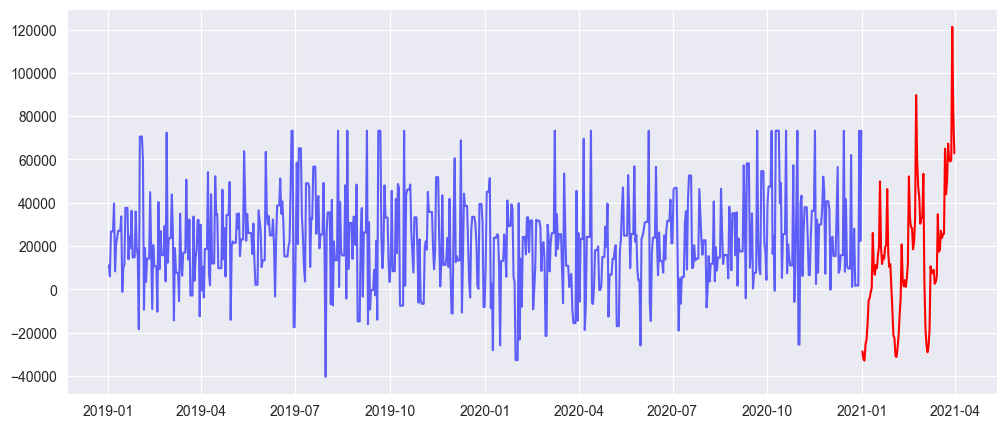

In [857]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', label="Predicted")
plt.show()

In [858]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_prophet_2.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -28694.30
1  Precision Analyst  2021-01-02             -32414.36
2  Precision Analyst  2021-01-03             -32924.33
3  Precision Analyst  2021-01-04             -25346.57
4  Precision Analyst  2021-01-05             -23221.84
